# Определение возраста покупателей
**Проект №14 Яндекс.Практикум - Data Science**

## Описание проекта

**Исходные данные:**

Набор фотографий людей с указанием возраста.

**Цель проекта:**

Построить модель для определения возраста по фотографии.

**Условия задачи:**

Метрика качества МАЕ должна быть меньше 8.0

## Исследовательский анализ данных

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Загрузка данных

In [2]:
DIR = '/datasets/faces/'
labels = pd.read_csv(DIR+'labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=DIR+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
print(f"Input count of foto: {len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])}")

Input count of foto: 1


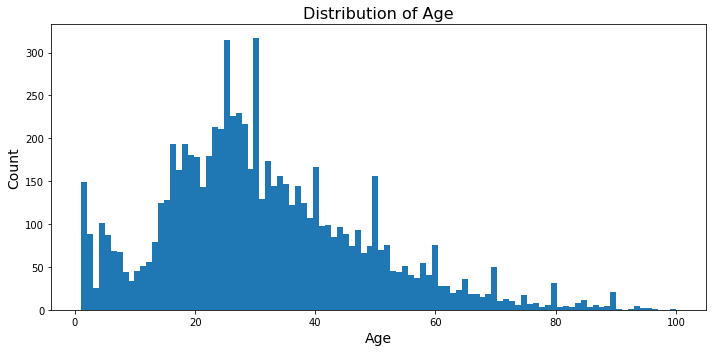

In [4]:
fig, ax = plt.subplots(tight_layout=True)
fig.set_size_inches(10, 5)

ax.hist(labels['real_age'], bins=100)
ax.set_title('Distribution of Age', fontsize=16)
ax.set_xlabel('Age', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

plt.show()

In [5]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Распределение близко к нормальному со средним значение возраста 31 и диапазоном от 1 до 100 лет. Наблюдается на гистограмме некоторая бимодальность из-за провала количества данных в районе 9-13 лет.

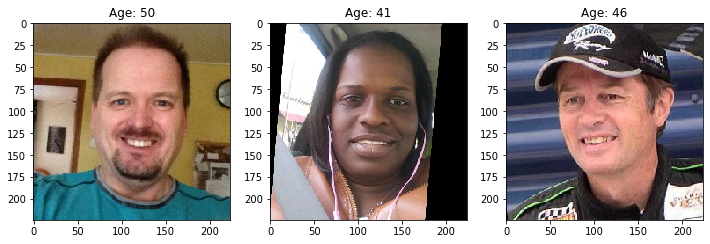

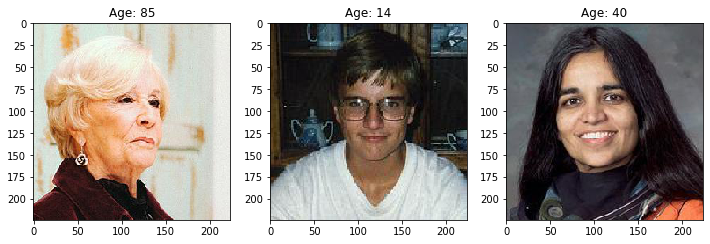

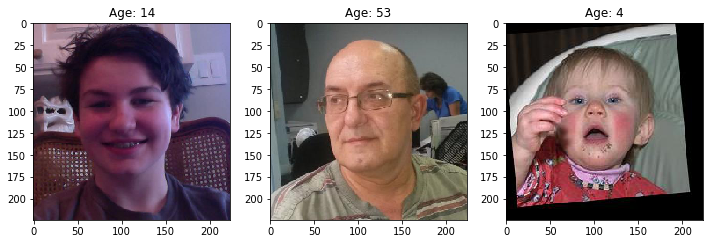

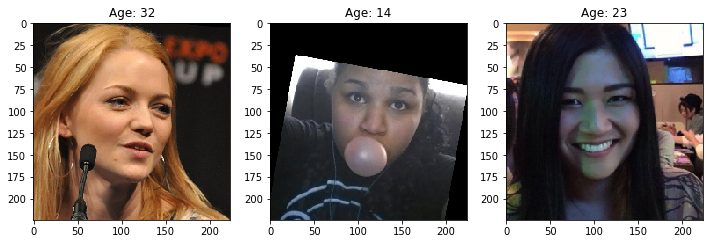

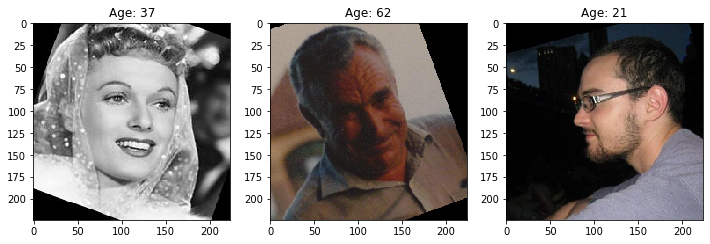

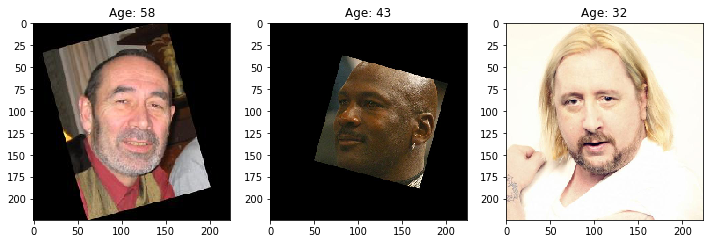

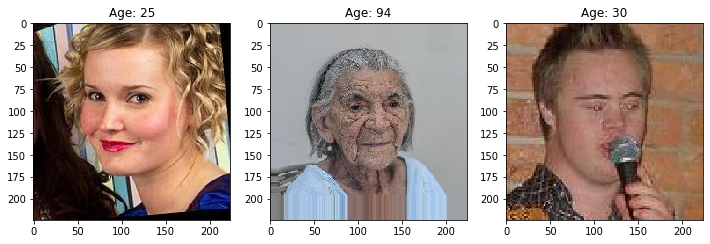

In [6]:
x, y = train_gen_flow.next()
for i in range(0,19,3):
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(12, 5)

    ax[0].set_title(f"Age: {y[i]}")
    ax[1].set_title(f"Age: {y[i+1]}")
    ax[2].set_title(f"Age: {y[i+2]}")
    ax[0].imshow(x[i])
    ax[1].imshow(x[i+1])
    ax[2].imshow(x[i+2])
    plt.show()

Некоторые фотографии искажены и на них трудно определить черты лица человека. Для более качественного обучения модели необходимо провести очистку данных.

## Обучение модели

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому приведён python код без исполнения.

```python
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd
import os


def load_train(path):
    labels = pd.read_csv(os.path.join(path, 'labels.csv'))
    train_datagen = ImageDataGenerator(rescale=1/255.,
                                        horizontal_flip=True,
                                        width_shift_range=0.1,
                                        validation_split=0.25)
                                      
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(os.path.join(path, 'labels.csv'))
    test_datagen = ImageDataGenerator(rescale=1/255.,
                                       validation_split=0.25)

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    backbone.trainable = True

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model 
```

Для обучающих данных была применена техника аугментации, изображения были дополены перевёрнутыми по горизонтали и сдвинутыми на 10%.

```
Вывод результата обучения модели:

Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Epoch 1/10
178/178 - 103s - loss: 225.5633 - mae: 10.7593 - val_loss: 817.3410 - val_mae: 23.6929
Epoch 2/10
178/178 - 95s - loss: 76.7614 - mae: 6.6185 - val_loss: 819.9181 - val_mae: 23.7529
Epoch 3/10
178/178 - 95s - loss: 57.4864 - mae: 5.7201 - val_loss: 243.8560 - val_mae: 11.3788
Epoch 4/10
178/178 - 95s - loss: 41.2411 - mae: 4.9452 - val_loss: 174.1531 - val_mae: 9.7887
Epoch 5/10
178/178 - 94s - loss: 33.7079 - mae: 4.4269 - val_loss: 77.5680 - val_mae: 6.6175
Epoch 6/10
178/178 - 95s - loss: 26.2811 - mae: 3.9941 - val_loss: 80.1971 - val_mae: 6.8075
Epoch 7/10
178/178 - 94s - loss: 22.1751 - mae: 3.6820 - val_loss: 66.9979 - val_mae: 6.1246
Epoch 8/10
178/178 - 95s - loss: 18.9803 - mae: 3.3855 - val_loss: 67.2849 - val_mae: 6.1803
Epoch 9/10
178/178 - 95s - loss: 15.8574 - mae: 3.0671 - val_loss: 88.4150 - val_mae: 7.3110
Epoch 10/10
178/178 - 95s - loss: 14.2998 - mae: 2.9074 - val_loss: 63.6059 - val_mae: 5.8922
60/60 - 10s - loss: 63.6059 - mae: 5.8922
Test MAE: 5.8922
```

## Вывод

Для обучения модели использовалась архитектура нейроной сети ResNet50. Данные были разделены в соотношении 3:1 на обучающие и валидационные. Модель была обучена на 10 эпохах с шагом алгоритма оптимизации Adam 0.0001, ддля оценки функции потерь использовался MSE. На валидационных данных было получено значение метрики качества МАЕ = 5.8922(лет).

В дальнейшем рекомендуется провести анализ работы модели на разных возрастах, вдруг качество модели сильно отличается в зависимости от возраста.